Deep Learning HW3- part 1

BY: Dema Omar , Aya Fodi


# Part 2: Latent Space Visualization

In this part, we explore **latent space representations** using a **Variational Autoencoder (VAE)** trained on the **MNIST** dataset.  
The goal is to understand how neural networks learn compressed, meaningful representations of input data and how these latent features capture similarities between samples.

---

### Objectives
1. **Implement from scratch:**
   - The **Encoder**  
   - The **Decoder**  
   - The **Variational Autoencoder (VAE)** architecture  
   - The **custom loss function** combining:
     - **Reconstruction Loss (BCE)**  
     - **KL Divergence**  

---

### Tasks
2. **Train the VAE** for 50 epochs (or more) to learn meaningful encodings.  
   Optionally, generate and visualize reconstructed digits every few epochs.  
3. **Implement visualization functions:**
   - Plot a **generated handwritten digit** from a sampled latent code.  
   - Plot the **latent space** colored by digit classes.  
   - Perform a **linear interpolation** between two latent codes:  
     \[
     \hat{x} = (1 - t)x_1 + t x_2, \quad t \in [0,1]
     \]
     Then decode and visualize the transition between digits.

---

### Expected Results
- Two clear **latent space visualizations** showing how digits are grouped.  
- Smooth interpolations between different digits, demonstrating how the model encodes transitions in latent space.  
- Insights into how neural networks learn to represent input data in lower-dimensional, meaningful spaces.


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torch.nn.init as init
import random
import cv2
import imageio

# Preprocessing

In [ ]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = 'C:/Users/demao/OneDrive/Documents/MNIST'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder Class

Here we define the Encoder for the VAE , it compresses input data into a latent representation by outputting mu (mean) and log_var (log variance).The weights are initialized using Xavier Initialization to improve training.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        # Output layer for mean
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        # Output layer for log variance
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Initialize weights using Xavier Uniform
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc_mu.weight)
        init.xavier_uniform_(self.fc_logvar.weight)

        #initialize the biases to zero
        self.fc1.bias.data.fill_(0)
        self.fc_mu.bias.data.fill_(0)
        self.fc_logvar.bias.data.fill_(0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

# Decoder Class

Here, we define the Decoder for the VAE ,it takes a latent representation as input and reconstructs the original data. The input passes through a fully connected layer with a ReLU activation,followed by another layer with a Sigmoid activation to scale the output between 0 and 1. The weights are initialized using Xavier Initialization to improve training stability.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights using Xavier Uniform
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)

        # Initialize biases to zero
        self.fc1.bias.data.fill_(0)
        self.fc2.bias.data.fill_(0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Variational Auto Encoder Class

Here, we define a Variational Autoencoder that compresses input data into a 2D latent space and reconstructs it. The Encoder transforms the input into a latent representation by outputting mu and log_var, which have only 2 dimensions. The Reparameterization Trick generates a latent vector z by sampling from the learned 2D distribution. The Decoder reconstructs the input from z. The model uses Xavier Initialization to improve training stability.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        self.device = device

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        # Latent space to mean and log-variance
        self.fc_mu = nn.Linear(latent_dim, 2)  # Outputs mean vector
        self.fc_logvar = nn.Linear(latent_dim, 2)  # Outputs log variance vector

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),  # Decoder starts from a dimension of 2
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, input_dim),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def encode(self, x):
        h1 = self.encoder(x)
        mu = self.fc_mu(h1)  #2 dimensions for mu
        log_var = self.fc_logvar(h1)  # 2 dimensions for log-variance
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(self.device)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [ ]:
lr = 0.001
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr)

In [ ]:
# Print the model architecture
print("VAE Model Architecture:")
print(model)

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal number of trainable parameters: {total_params}")

VAE Model Architecture:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=200, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=400, out_features=800, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=800, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

Total number of trainable parameters: 1424788


# Loss Function Class


Here the  loss for the Variational Autoencoder , it combines two parts:
Reconstruction loss: measures how well the reconstructed output (x_hat) matches the original input (x) using Binary Cross Entropy.
KL Divergence:ensures the latent space follows a normal distribution by penalizing deviations from it.
The total loss is the sum of these two terms

In [ ]:
def loss_function(x, x_hat, mean, log_var):

    loss_reprod = -torch.sum(x * torch.log(x_hat + 1e-10) + (1 - x) * torch.log(1 - x_hat + 1e-10))
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return loss_reprod + KLD

# Training Loop

Here we train the  Variational Autoencoder , it loops through multiple epochs, processes data in batches, and calculates the loss using reconstruction loss and KL divergence. After each batch, it updates the model's weights using backpropagation. Every 10 epochs, the model is evaluated on a test batch, showing original and reconstructed images for visual evaluation.

In [ ]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))


        # Add evaluation step every 10 epochs
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                sample_x, _ = next(iter(test_loader))  # Take samples from the test set
                sample_x = sample_x.view(batch_size, x_dim).to(device)
                reconstructed_x, _, _ = model(sample_x)

           # Display original and reconstructed images
            fig, axes = plt.subplots(2, 10, figsize=(10, 2))
            for i in range(10):
                axes[0, i].imshow(sample_x[i].cpu().numpy().reshape(28, 28), cmap="gray")
                axes[0, i].axis('off')
                axes[1, i].imshow(reconstructed_x[i].cpu().numpy().reshape(28, 28), cmap="gray")
                axes[1, i].axis('off')
            plt.show()
            model.train()  # Back to training mode

    return overall_loss

	Epoch 1 	Average Loss:  180.20516725466925
	Epoch 2 	Average Loss:  160.004871139399
	Epoch 3 	Average Loss:  154.90244230292674
	Epoch 4 	Average Loss:  152.07572127047683
	Epoch 5 	Average Loss:  150.21567710507094
	Epoch 6 	Average Loss:  148.88446331450857
	Epoch 7 	Average Loss:  147.74403183365504
	Epoch 8 	Average Loss:  147.11155200073037
	Epoch 9 	Average Loss:  146.1688740837594
	Epoch 10 	Average Loss:  145.5505523528798


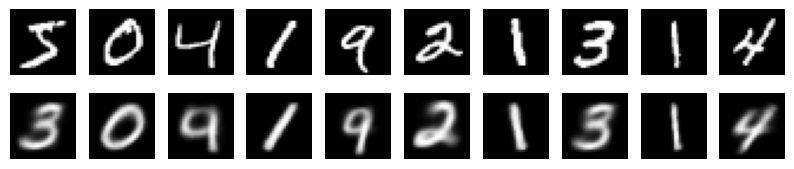

	Epoch 11 	Average Loss:  145.15541757421224
	Epoch 12 	Average Loss:  144.63880282241234
	Epoch 13 	Average Loss:  144.23356691491026
	Epoch 14 	Average Loss:  143.93190879656197
	Epoch 15 	Average Loss:  143.43300001956385
	Epoch 16 	Average Loss:  143.1034579931396
	Epoch 17 	Average Loss:  142.88916760681866
	Epoch 18 	Average Loss:  142.59255386581802
	Epoch 19 	Average Loss:  142.37713109088062
	Epoch 20 	Average Loss:  142.19727437982576


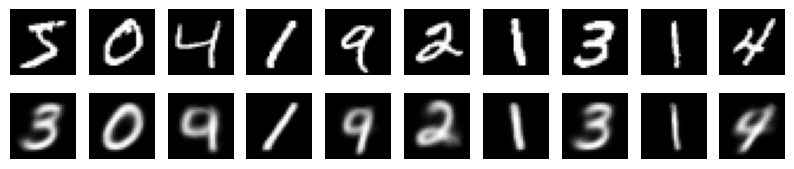

	Epoch 21 	Average Loss:  142.00757525563438
	Epoch 22 	Average Loss:  141.63848469780362
	Epoch 23 	Average Loss:  141.6271140051127
	Epoch 24 	Average Loss:  141.29519616026712
	Epoch 25 	Average Loss:  141.24070540744992
	Epoch 26 	Average Loss:  141.1505636673101
	Epoch 27 	Average Loss:  140.77634115126773
	Epoch 28 	Average Loss:  140.59263008334202
	Epoch 29 	Average Loss:  140.4915742872235
	Epoch 30 	Average Loss:  140.29758725479968


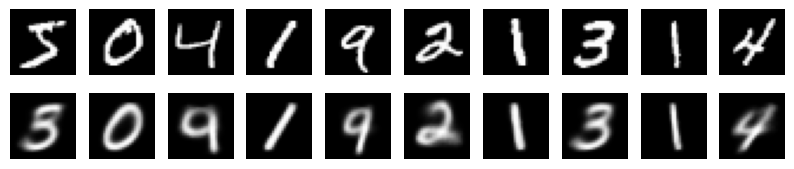

	Epoch 31 	Average Loss:  140.38770467054465
	Epoch 32 	Average Loss:  140.08265165249375
	Epoch 33 	Average Loss:  140.1361807113418
	Epoch 34 	Average Loss:  139.95886389425084
	Epoch 35 	Average Loss:  139.8209713128652
	Epoch 36 	Average Loss:  139.67526355775252
	Epoch 37 	Average Loss:  139.41607050161727
	Epoch 38 	Average Loss:  139.57412720745512
	Epoch 39 	Average Loss:  139.11860245591612
	Epoch 40 	Average Loss:  139.182208482236


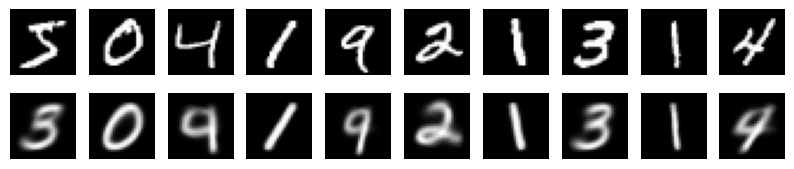

	Epoch 41 	Average Loss:  139.26533638420804
	Epoch 42 	Average Loss:  139.02831380751775
	Epoch 43 	Average Loss:  138.98004313830342
	Epoch 44 	Average Loss:  138.93676157854236
	Epoch 45 	Average Loss:  138.69398512494783
	Epoch 46 	Average Loss:  138.7021378241079
	Epoch 47 	Average Loss:  138.58718300031302
	Epoch 48 	Average Loss:  138.57789378782346
	Epoch 49 	Average Loss:  138.5807138688178
	Epoch 50 	Average Loss:  138.2331908486801


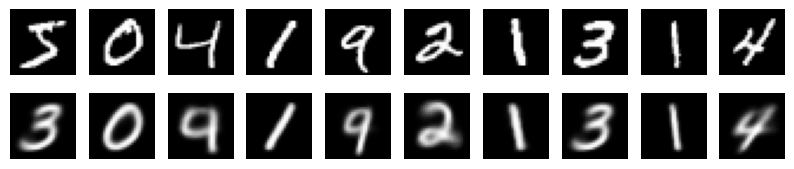

8280168.1318359375

In [ ]:
train(model, optimizer, epochs=50, device=device)

# Generate and plot digit

Here we generate a new image using the VAE , it takes a mean and variance as input, applies the reparameterization trick to create a latent vector, and then uses the decoder of the VAE to generate a new image. The image is then displayed using matplotlib in grayscale.

In [ ]:
def generate_digit(mean, var):
    model.eval()  # Set model to evaluation mode

    latent_vector = torch.tensor([[mean, var]], dtype=torch.float, device=device)

    with torch.no_grad():
        generated_image = model.decode(latent_vector).cpu().view(28, 28)

    def plot_digit():
        plt.imshow(generated_image.numpy(), cmap='gray')
        plt.axis('off')
        plt.show()

    plot_digit()  # Call the inner function to display the image

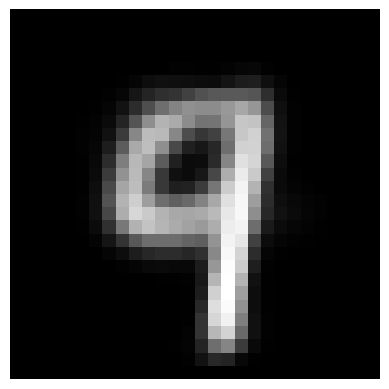

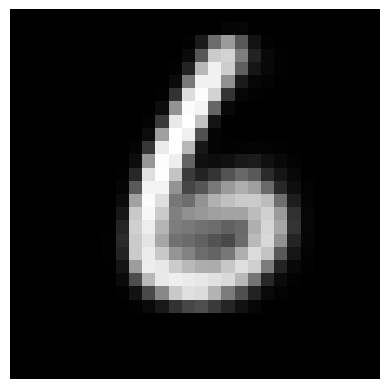

(None, None)

In [ ]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

# Latent Space Grid Visualization

This code visualizes the latent space of the VAE, it creates a grid of points in the latent space, generates images for each point using the VAE's decoder, and displays them in a grid.

In [ ]:
def plot_latent_space(model, scale, digit_size=28, figsize=15):
    n = 20  # Number of images per axis
    model.eval()

    # Prepare the figure space
    combined_image = np.zeros((digit_size * n, digit_size * n))

    # Setting up the grid of z values
    x_values = np.linspace(-scale, scale, n)
    y_values = np.linspace(-scale, scale, n)[::-1]

    # Loop through each coordinate in the grid
    for i, y in enumerate(y_values):
        for j, x in enumerate(x_values):
            # Prepare the latent vector
            latent_vector = torch.tensor([[x, y]], dtype=torch.float).to(model.device)
            output_image = model.decode(latent_vector).view(digit_size, digit_size).detach().cpu().numpy()
            # Insert the image into the correct spot in the combined image array
            combined_image[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = output_image

    # Displaying the image grid
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(combined_image, cmap='gray')
    plt.axis('off')
    plt.show()

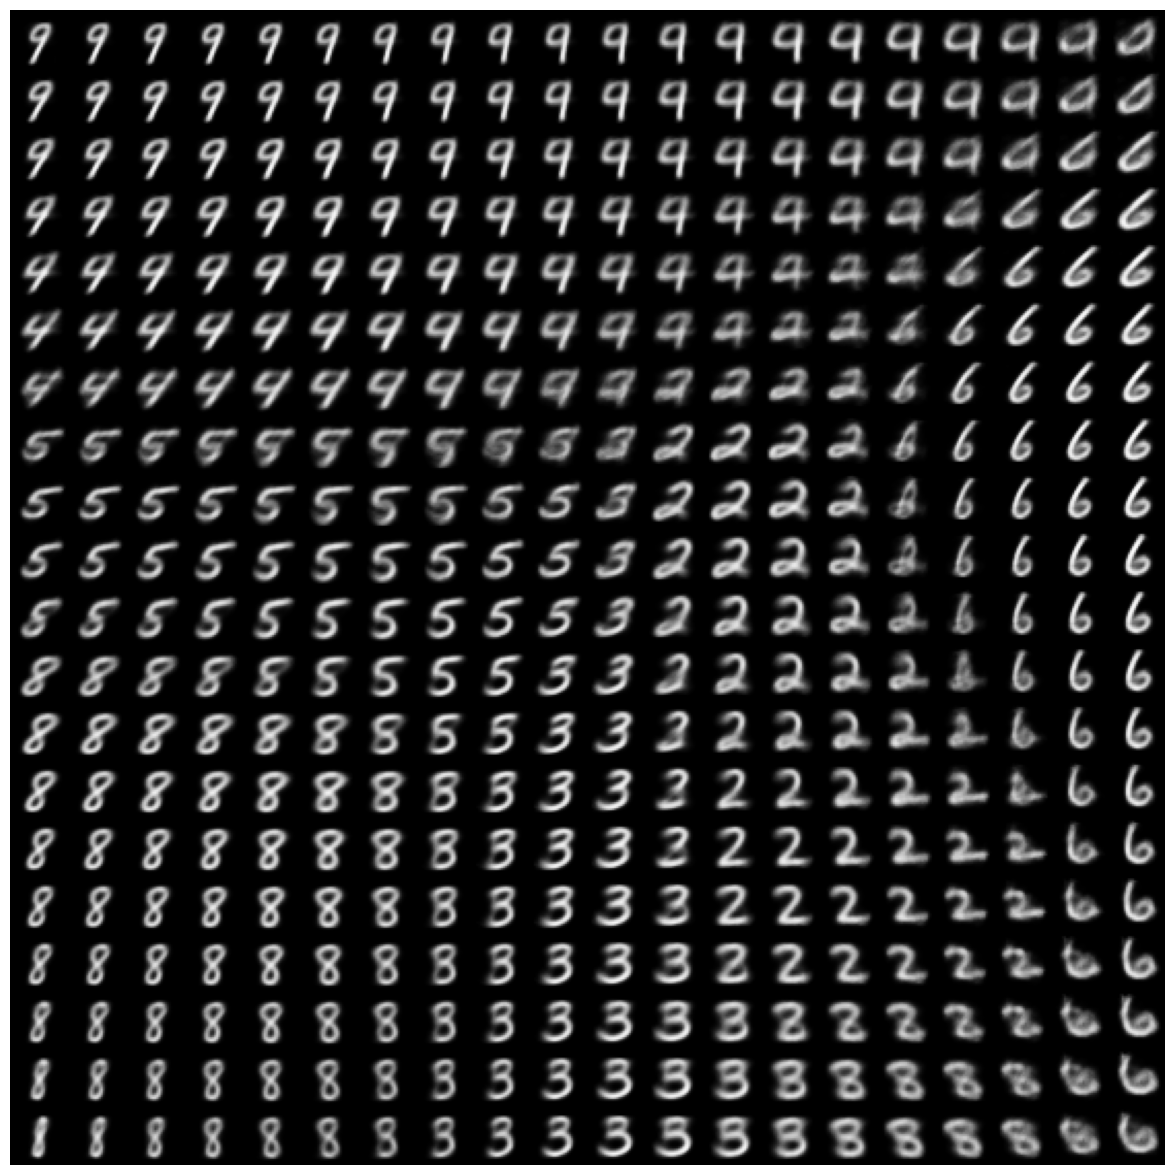

In [ ]:
plot_latent_space(model, scale=1.0)

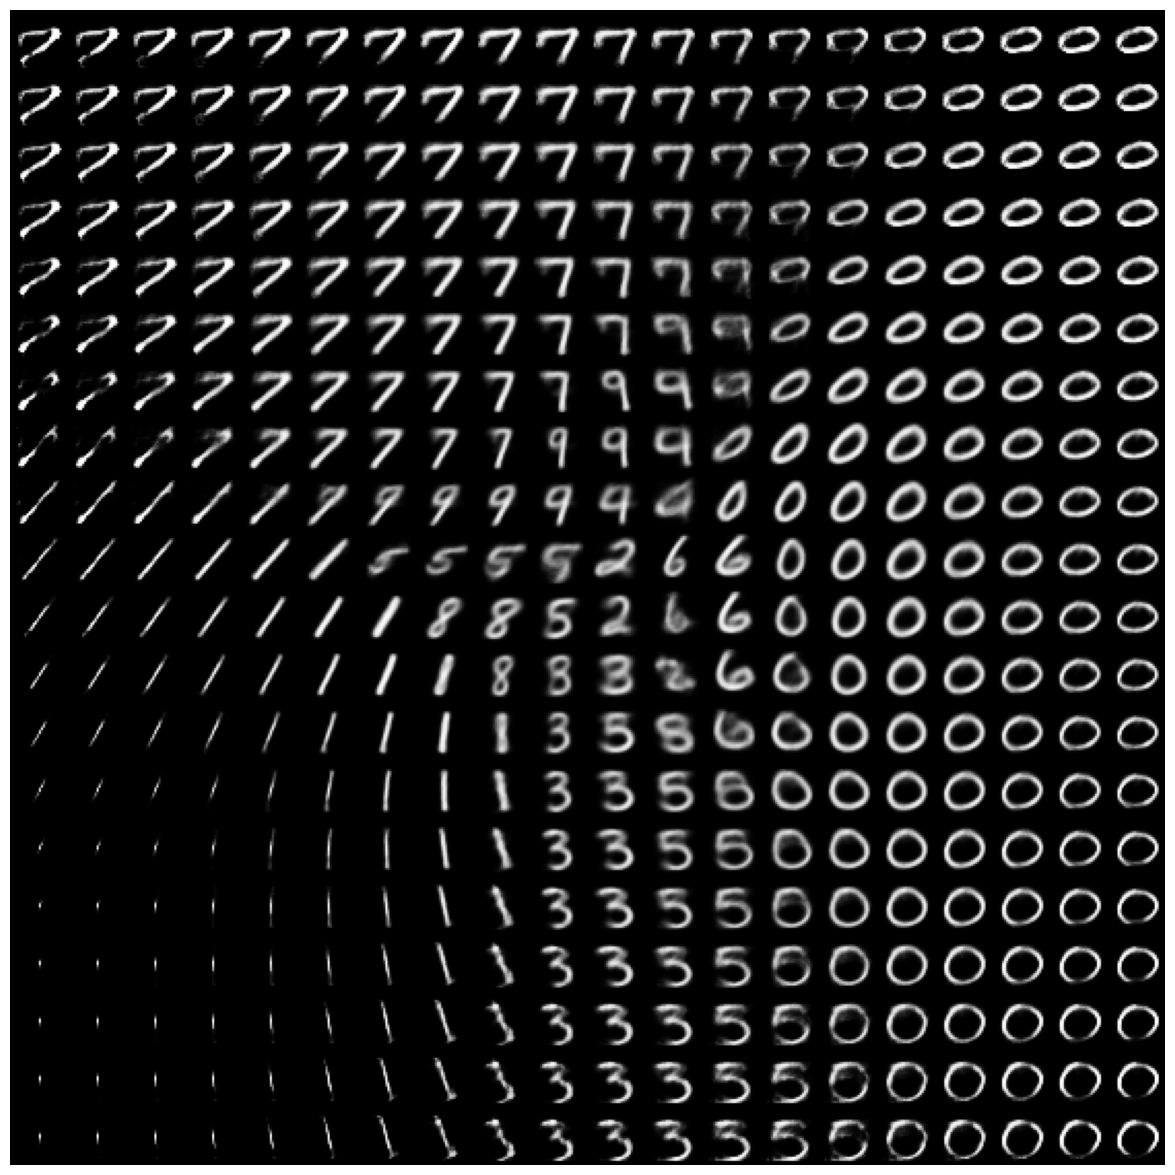

In [ ]:
plot_latent_space(model, scale=5.0)

# Linear Interpolation

Here the function generates a smooth transition between two randomly selected digit images by interpolating between their latent space representations. It encodes both digits, performs a linear interpolation between their latent vectors, and then decodes the interpolated values back into images. Finally, it displays the generated sequence of images to visualize the gradual transformation from one digit to another.

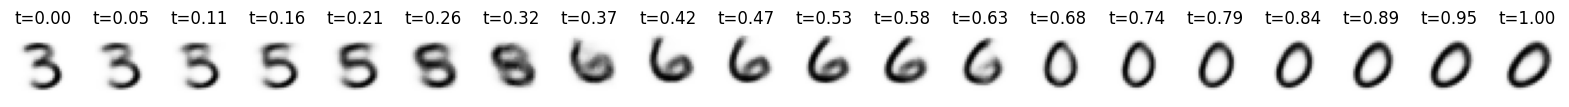

In [ ]:
def interpolate_between_two_digits(model, data_loader, steps=20):
    model.eval()

    # Retrieve a batch from the data loader
    images, labels = next(iter(data_loader))

    # Select two random digits
    idx1, idx2 = np.random.choice(len(images), 2, replace=False)
    first_img, second_img = images[idx1].to(device), images[idx2].to(device)

    # Reshape images for processing
    first_img = first_img.view(1, -1)
    second_img = second_img.view(1, -1)

    with torch.no_grad():
        # Obtain latent vectors for both images
        first_mean, first_logvar = model.encode(first_img)
        second_mean, second_logvar = model.encode(second_img)

    # Linearly interpolate between the two latent vectors
    z_first = first_mean.squeeze(0)
    z_second = second_mean.squeeze(0)
    transition_images = []

    # Generate and collect interpolated images
    for t in np.linspace(0, 1, steps):
        z_interpolated = z_first * (1 - t) + z_second * t
        with torch.no_grad():
            reconstructed_img = model.decode(z_interpolated.unsqueeze(0))
        img = reconstructed_img.detach().cpu().reshape(28, 28)
        transition_images.append(img)

    # Display the sequence of interpolated images
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
    for index, ax in enumerate(axes):
        ax.imshow(transition_images[index].numpy(), cmap='Greys')
        ax.set_title(f"t={np.linspace(0, 1, steps)[index]:.2f}")
        ax.axis('off')  # Hide the axes

    plt.show()
    return transition_images  # Return the list of images after showing them

# Run the function
interpolated_images = interpolate_between_two_digits(model, test_loader)